# Google Play Store Exploratory Analysis

Dataset available on https://www.kaggle.com/lava18/google-play-store-apps

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

sns.set_theme(style='darkgrid', palette='Set3')

# Loading and checking datasets

In [2]:
df_apps = pd.read_csv('datasets/googleplaystore.csv')
df_apps.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [3]:
df_apps.shape

(10841, 13)

In [4]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df_apps.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
df_reviews = pd.read_csv('datasets/googleplaystore_user_reviews.csv')
df_reviews.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN


In [7]:
df_reviews.shape

(64295, 5)

In [8]:
df_reviews.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

# Data Cleaning

## Deleting irrelevant data

In [9]:
df_apps.drop(['Last Updated', 'Current Ver'], axis=1, inplace=True)
df_apps.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,4.0.3 and up


## Dealing with missing information

### Type

* There's only 1 App without 'Type', so we'll be fixing this manually

In [10]:
df_apps[df_apps['Type'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,Varies with device


In [11]:
# Type according to Google Play Store (23/03/21)
type_column = df_apps.columns.get_loc('Type')
df_apps.iloc[9148, type_column] = 'Free'

In [12]:
df_apps['Type'].value_counts()

Free    10040
Paid      800
0           1
Name: Type, dtype: int64

* There's 1 App with 'Type' = 0. Let's take a look at it:

In [13]:
df_apps[df_apps['Type'] == '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",NaN


* This row values have been misplaced. We'll be fixing it:

In [14]:
df_apps.iloc[10472] = df_apps.iloc[10472].replace(['1.9', 19.0, '3.0M', '1,000+', 'Free', '0', 'Everyone', 'February 11, 2018'], ['LIFESTYLE', 1.9, '19.0', '3.0M', '1,000+', 'Free', '0', 'Lifestyle'])

version_column = df_apps.columns.get_loc('Android Ver')
df_apps.iloc[10472, version_column] = '4.0 and up'

content_rating_column = df_apps.columns.get_loc('Content Rating')
df_apps.iloc[10472, content_rating_column] = 'Everyone'

In [15]:
df_apps['Type'].value_counts()

Free    10041
Paid      800
Name: Type, dtype: int64

### Android Ver

* There are 2 Apps without 'Android Ver'. We'll be filling them with the most common Android Version

In [16]:
most_common_android = df_apps['Android Ver'].value_counts().idxmax()
df_apps['Android Ver'].fillna(most_common_android, inplace=True)

### Rating

* There are a lot of 'NaN' values in this column. We'll be filling them with the mean of all other ratings.

In [17]:
ratings_mean = df_apps['Rating'].mean()
#df_apps['Rating'].fillna(ratings_mean, inplace=True)
df_apps['Rating'].fillna(0, inplace=True)

In [18]:
df_apps.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Android Ver       0
dtype: int64

### Reviews

* There are a lot o 'NaN' values in the review dataset. We'll be dropping them.

In [19]:
df_reviews.dropna(inplace=True)

In [20]:
df_reviews.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [21]:
df_apps.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,4.0.3 and up


## Changing data types

### Review (to numeric)

In [22]:
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'])

### Installs (to numeric)

In [23]:
df_apps['Installs'] = df_apps['Installs'].apply(lambda x: float(x[:-1].replace(',', '')) if x[-1] == '+' else float(x))

### Size (to numeric - in kilobytes)

In [24]:
# Converts the App Size to kilobytes (Size will be 0 if 'Varies with Device')
df_apps['Size'] = df_apps['Size'].apply(lambda x: float(x[:-1])*1024 if x[-1] == 'M' else(float(x[:-1]) if x[-1] == 'k' else 0))

### Price (to numeric - in dollars)

In [25]:
df_apps['Price'] = df_apps['Price'].apply(lambda x: float(x[1:]) if x[0] == '$' else float(x))

### Android Version (remove part of the text )

In [26]:
df_apps['Android Ver'] = df_apps['Android Ver'].apply(lambda x: x.split(' ')[0])

# Visualization

In [27]:
print(f'{df_apps.shape[0]} Android Apps')

10841 Android Apps


### Top Google Play App Categories

* What are the most popular app categories on Google Play Store?

In [28]:
print(f"There are {df_apps['Category'].unique().shape[0]} different App Categories")

There are 33 different App Categories


In [29]:
top_android_apps = df_apps['Category'].value_counts().head(15)
labels = top_android_apps.index.tolist()
labels.append('OTHER')
values = top_android_apps.values.tolist()
values.append(df_apps.shape[0] - top_android_apps.sum())

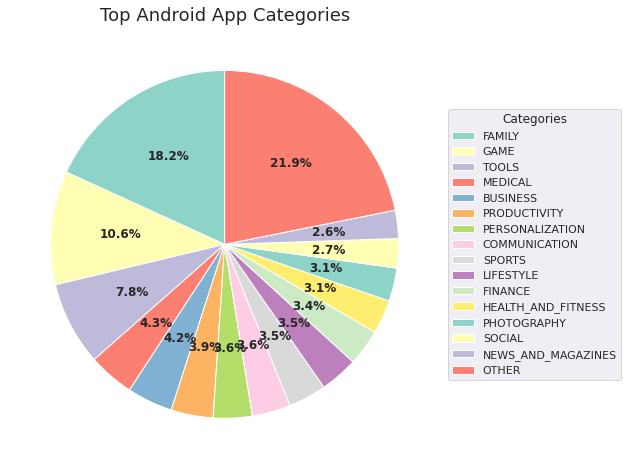

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')

ax.legend(wedges, labels,
          title='Categories',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight='bold')
ax.set_title("Top Android App Categories", fontsize=18)
plt.show()

In [31]:
top_android_apps = df_apps['Category'].value_counts()
labels = top_android_apps.index.tolist()
values = top_android_apps.values.tolist()

cmap = matplotlib.cm.Greens
mini = min(df_apps['Category'].value_counts())
maxi = max(df_apps['Category'].value_counts())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in df_apps['Category'].value_counts()]

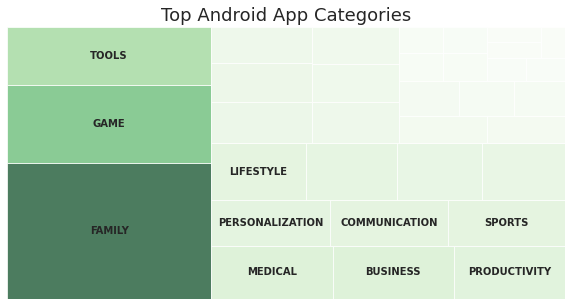

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
squarify.plot(values, label=labels[:10], color=colors, alpha=0.7, text_kwargs={'fontsize': 10, 'weight': 'bold'})
ax.axis('off')
ax.set_title("Top Android App Categories", fontsize=18)
plt.show()

* <strong>Family</strong>, <strong>Game</strong> and <strong>Tools</strong> are the top app categories

* The <strong>other</strong> 30 categories represent <strong>63.5%</strong> of the applications. But <strong>each category</strong> is responsible for <strong>less than 5%</strong> of the applications.

### Rating Distribution

### Rating Distribution across the top 3 categories